Importing required Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
import seaborn as sns
import random
import os
from PIL import Image,ImageFile
from collections import defaultdict



Understanding the dataset  
1.Number of Images in each of the 3 folders(train,test,valid)  
2.Size of the images

In [2]:
base_dir = "Wildfire"
splits = ['train','test','valid']
labels = ['wildfire', 'nowildfire']

image_counts = defaultdict(int)

for split in splits:
    for label in labels:
        folder_path = os.path.join(base_dir, split, label)
        if os.path.exists(folder_path):
            count = len([
                f for f in os.listdir(folder_path)
                if f.lower().endswith('.jpg')
            ])
            image_counts[f'{split}/{label}'] = count

# Print the result
for key, count in image_counts.items():
    print(f"{key}: {count} images")

train/wildfire: 15750 images
train/nowildfire: 14500 images
test/wildfire: 3480 images
test/nowildfire: 2820 images
valid/wildfire: 3480 images
valid/nowildfire: 2820 images


In [3]:
sample_path = os.path.join(base_dir, 'train', 'wildfire')
sample_image = os.listdir(sample_path)[0]
with Image.open(os.path.join(sample_path, sample_image)) as img:
    print("Image size :", img.size)

Image size : (350, 350)


Removing corrupted Images

In [4]:
# This function removes corrupted images 
def clean_corrupted_images(folder_path):
    removed = 0
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith('jpg'):
                try:
                    img_path = os.path.join(root, file)
                    with Image.open(img_path) as img:
                        img.verify()  
                except (IOError, SyntaxError, OSError):
                    os.remove(img_path)
                    removed += 1
                    print(f"Removed corrupted image: {img_path}")
    print(f"Removed {removed} corrupted images.")

# Example: Run it on your Wildfire dataset root
clean_corrupted_images("Wildfire")
ImageFile.LOAD_TRUNCATED_IMAGES = True # makes sure if some of the corrupted images are not deleted they would be partially loaded an won't crash while training

Removed 0 corrupted images.


Creating a Pandas Dataframe of the Wildfire dataset

In [5]:
# creating 3 dataframes for training,testing and validation with 2 columns [Image(path of the image),label(nowildfire or wildfire)]
def create_image_dataframe(base_dir):
    data = []
    for label in ['wildfire', 'nowildfire']:
        class_dir = os.path.join(base_dir, label)
        if not os.path.exists(class_dir):
            continue
        for filename in os.listdir(class_dir):
            if filename.lower().endswith('.jpg'):
                filepath = os.path.join(class_dir, filename)
                data.append({'Image': filepath, 'label': label})
    return pd.DataFrame(data)


train_df = create_image_dataframe(os.path.join(base_dir, 'train'))
test_df = create_image_dataframe(os.path.join(base_dir, 'test'))
valid_df = create_image_dataframe(os.path.join(base_dir, 'valid'))


print("Train Data:")
print(train_df.head(3))
print("\nTest Data:")
print(test_df.head(3))
print("\nValid Data:")
print(valid_df.tail(3))

Train Data:
                                            Image     label
0  Wildfire\train\wildfire\-57.11902,51.47242.jpg  wildfire
1   Wildfire\train\wildfire\-57.8088,51.44634.jpg  wildfire
2     Wildfire\train\wildfire\-58.657,51.1945.jpg  wildfire

Test Data:
                                           Image     label
0  Wildfire\test\wildfire\-59.03238,51.85132.jpg  wildfire
1   Wildfire\test\wildfire\-60.6867,50.26079.jpg  wildfire
2  Wildfire\test\wildfire\-60.73875,50.24761.jpg  wildfire

Valid Data:
                                                  Image       label
6297  Wildfire\valid\nowildfire\-79.736499,43.860899...  nowildfire
6298  Wildfire\valid\nowildfire\-79.740504,43.718047...  nowildfire
6299  Wildfire\valid\nowildfire\-79.743038,43.881941...  nowildfire


Converting Labels into numeric form (Label Encoding)  
nowildfire = 0  
wildfire = 1



In [6]:
labels = {'nowildfire': 0, 'wildfire': 1}
train_df['label'] = train_df['label'].map(labels)
test_df['label'] = test_df['label'].map(labels)
valid_df['label'] = valid_df['label'].map(labels)

In [7]:
print(valid_df.tail(3))

                                                  Image  label
6297  Wildfire\valid\nowildfire\-79.736499,43.860899...      0
6298  Wildfire\valid\nowildfire\-79.740504,43.718047...      0
6299  Wildfire\valid\nowildfire\-79.743038,43.881941...      0


Visualizing the images in the dataframe

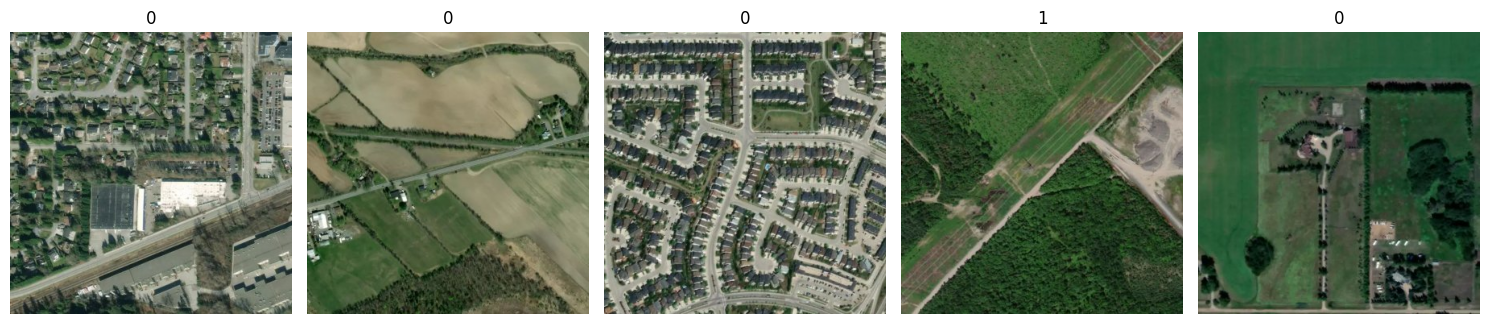

In [8]:
def visualize_random_images(df, num_images):
    sample = df.sample(num_images)
    plt.figure(figsize=(15, 5))
    
    for i, (_, row) in enumerate(sample.iterrows()):
        img = Image.open(row['Image'])
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(row['label'])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_random_images(train_df, 5)

Normalizing the Images by scaling pixel values to [0,1] range


In [9]:
img_height, img_width = 128, 128 #defining size of the image

datagen = ImageDataGenerator(rescale=1./255) # normailzing images to [0,1]

train_cnn = datagen.flow_from_dataframe(
    train_df,
    x_col='Image',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='raw',
    batch_size=32,
    shuffle=True
)

valid_cnn = datagen.flow_from_dataframe(
    valid_df,
    x_col='Image',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

test_cnn = datagen.flow_from_dataframe(
    test_df,
    x_col='Image',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='raw',
    batch_size=32,
    shuffle=False
)

Found 30250 validated image filenames.
Found 6300 validated image filenames.
Found 6300 validated image filenames.


Building the CNN Model


In [10]:
model1 = models.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=(128,128, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # as it is a binary classification problem sigmoid activation is used
])

model1.compile(
    optimizer='adam', 
    loss='binary_crossentropy', # binary classification 
    metrics=['accuracy']
    )

model1.summary()

d:\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,705,921 (14.14 MB)

 Trainable params: 3,705,921 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:

cnn = model1.fit(train_cnn, validation_data=valid_cnn, epochs=10)

Epoch 1/10


d:\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


946/946 ━━━━━━━━━━━━━━━━━━━━ 117s 122ms/step - accuracy: 0.8784 - loss: 0.2999 - val_accuracy: 0.9410 - val_loss: 0.1510
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 116s 122ms/step - accuracy: 0.9363 - loss: 0.1715 - val_accuracy: 0.9452 - val_loss: 0.1368
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 113s 120ms/step - accuracy: 0.9443 - loss: 0.1520 - val_accuracy: 0.9565 - val_loss: 0.1150
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 114s 120ms/step - accuracy: 0.9519 - loss: 0.1303 - val_accuracy: 0.9270 - val_loss: 0.2176
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 115s 121ms/step - accuracy: 0.9578 - loss: 0.1194 - val_accuracy: 0.9565 - val_loss: 0.1143
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 115s 122ms/step - accuracy: 0.9609 - loss: 0.1084 - val_accuracy: 0.9500 - val_loss: 0.1435
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 114s 120ms/step - accuracy: 0.9647 - loss: 0.0945 - val_accuracy: 0.9625 - val_loss: 0.1286
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 113s 120ms/step - accuracy: 0.9713 - loss: 0.08

Evaluating the Loss & Accuracy on Test dataset


In [12]:
loss, accuracy = model1.evaluate(test_cnn)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}")


197/197 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - accuracy: 0.9712 - loss: 0.1246
Test Loss: 0.1418
Test Accuracy: 96.49


197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step


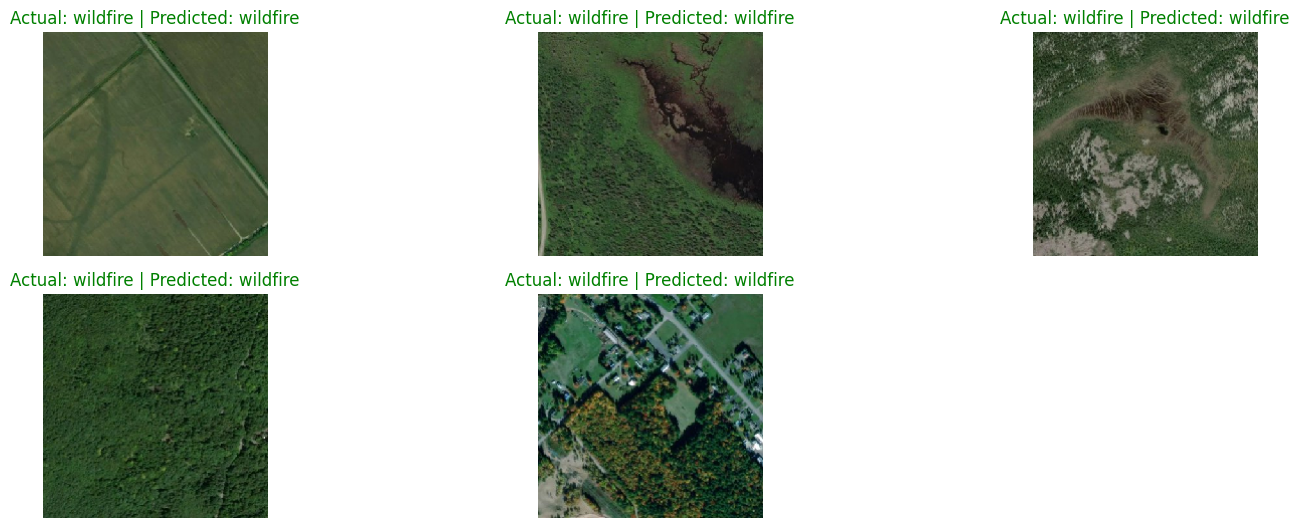

In [13]:
# Label mapping
label_map = {0: 'nowildfire', 1: 'wildfire'}

# Get predictions
preds = model1.predict(test_cnn)
pred_labels = (preds > 0.5).astype(int).flatten()

# True labels and filepaths 
true_labels = test_cnn.labels
filepaths = test_cnn.filepaths

num_samples = 5
indices = random.sample(range(len(filepaths)), num_samples)

# Plot
plt.figure(figsize=(15, 8))
for i, idx in enumerate(indices):
    img = image.load_img(filepaths[idx], target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    
    plt.subplot(3, 3, i + 1)
    plt.imshow(img_array)
    
    actual = label_map[true_labels[idx]]
    predicted = label_map[pred_labels[idx]]
    
    plt.title(f"Actual: {actual} | Predicted: {predicted}",
              color='green' if actual == predicted else 'red')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=['nowildfire', 'wildfire']))

Classification Report:
              precision    recall  f1-score   support

  nowildfire       0.97      0.95      0.96      2820
    wildfire       0.96      0.98      0.97      3480

    accuracy                           0.96      6300
   macro avg       0.97      0.96      0.96      6300
weighted avg       0.97      0.96      0.96      6300



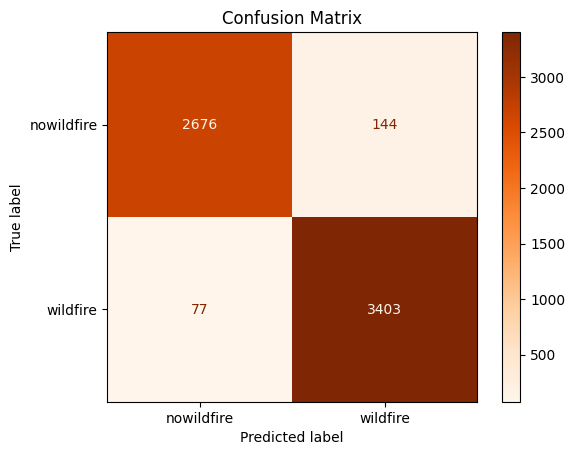

In [15]:
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['nowildfire', 'wildfire'])
disp.plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix")
plt.show()

3310 - Correctly predicted wildfires.  
2756 - Correctly predicted non-wildfires.  
64 - Predicted wildfire, but actually no wildfire.  
170 - Predicted no wildfire, but it was actually a wildfire.  

ResNet Model


In [16]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_gen = ImageDataGenerator(preprocessing_function=preprocess_input)


train_net = train_gen.flow_from_dataframe(
    train_df,
    x_col='Image', 
    y_col='label',
    target_size=(224, 224), 
    class_mode='raw', 
    batch_size=32,
    shuffle=False
    )

test_net = test_gen.flow_from_dataframe(
    test_df, 
    x_col='Image', 
    y_col='label',
    target_size=(224, 224), 
    class_mode='raw', 
    batch_size=32,
    shuffle=False
    )

valid_net = valid_gen.flow_from_dataframe(
    valid_df, 
    x_col='Image', 
    y_col='label',
    target_size=(224, 224), 
    class_mode='raw', 
    batch_size=32,
    shuffle=False
    )


Found 30250 validated image filenames.
Found 6300 validated image filenames.
Found 6300 validated image filenames.


In [17]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freezing the base model layers

model2 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
],name='ResNet_Prediction')

model2.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
    )

model2.summary()

Model: "ResNet_Prediction"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [18]:
resnet = model2.fit(train_net, validation_data=valid_net, epochs=10)

Epoch 1/10


d:\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


946/946 ━━━━━━━━━━━━━━━━━━━━ 1068s 1s/step - accuracy: 0.8985 - loss: 0.2954 - val_accuracy: 0.9675 - val_loss: 0.0886
Epoch 2/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 1061s 1s/step - accuracy: 0.9530 - loss: 0.1278 - val_accuracy: 0.9687 - val_loss: 0.0841
Epoch 3/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 1064s 1s/step - accuracy: 0.9613 - loss: 0.1027 - val_accuracy: 0.9689 - val_loss: 0.0861
Epoch 4/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 1058s 1s/step - accuracy: 0.9664 - loss: 0.0904 - val_accuracy: 0.9757 - val_loss: 0.0688
Epoch 5/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 1060s 1s/step - accuracy: 0.9735 - loss: 0.0769 - val_accuracy: 0.9756 - val_loss: 0.0719
Epoch 6/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 1062s 1s/step - accuracy: 0.9723 - loss: 0.0731 - val_accuracy: 0.9792 - val_loss: 0.0613
Epoch 7/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 1059s 1s/step - accuracy: 0.9738 - loss: 0.0698 - val_accuracy: 0.9808 - val_loss: 0.0577
Epoch 8/10
946/946 ━━━━━━━━━━━━━━━━━━━━ 1225s 1s/step - accuracy: 0.9764 - loss: 0.0649 - val_accurac

Loss and Accuracy for ResNet50


In [19]:

loss, accuracy = model2.evaluate(test_net)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}")

197/197 ━━━━━━━━━━━━━━━━━━━━ 187s 947ms/step - accuracy: 0.9656 - loss: 0.0925
Test Loss: 0.0625
Test Accuracy: 97.81


In [20]:
from sklearn.metrics import classification_report,precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_curve, auc

# Get ground truth labels directly from the test dataframe
y_true = test_df['label'].values.astype(int)
class_names = ['nowildfire', 'wildfire']

def get_predictions(model, generator):
    generator.reset()
    y_probs = model.predict(generator, verbose=1)
    y_pred = (y_probs > 0.5).astype(int)
    return y_probs.flatten(), y_pred

# Get predictions for both models
probs_cnn, pred_cnn = get_predictions(model1, test_cnn)
probs_resnet, pred_resnet = get_predictions(model2, test_net)


197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 188s 944ms/step


In [21]:
# Print classification reports
print("Custom CNN Classification Report:")
print(classification_report(y_true, pred_cnn, target_names=class_names))

print("ResNet50 Classification Report:")
print(classification_report(y_true, pred_resnet, target_names=class_names))

Custom CNN Classification Report:
              precision    recall  f1-score   support

  nowildfire       0.97      0.95      0.96      2820
    wildfire       0.96      0.98      0.97      3480

    accuracy                           0.96      6300
   macro avg       0.97      0.96      0.96      6300
weighted avg       0.97      0.96      0.96      6300

ResNet50 Classification Report:
              precision    recall  f1-score   support

  nowildfire       0.96      1.00      0.98      2820
    wildfire       1.00      0.96      0.98      3480

    accuracy                           0.98      6300
   macro avg       0.98      0.98      0.98      6300
weighted avg       0.98      0.98      0.98      6300



In [22]:
# Creating a metrics dataframe that stores accuracy ,preccison,recall ,f1score for both models Custom CNN and ResNet50
def metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred)
    }

metrics_cnn = metrics(y_true, pred_cnn)
metrics_resnet = metrics(y_true, pred_resnet)

# Combine into DataFrame
df_metrics = pd.DataFrame([metrics_cnn, metrics_resnet], index=["Custom CNN", "ResNet50"])
print(df_metrics)

            Accuracy  Precision    Recall  F1-Score
Custom CNN  0.964921   0.959402  0.977874  0.968550
ResNet50    0.978095   0.996730  0.963506  0.979836


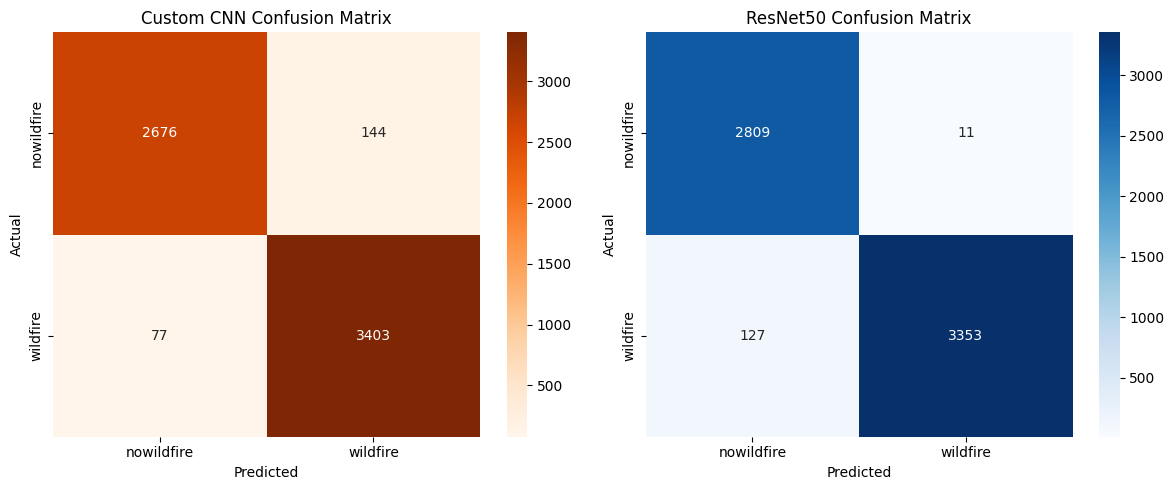

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# CNN Confusion Matrix
sns.heatmap(confusion_matrix(y_true, pred_cnn), annot=True, fmt='d', ax=axs[0], cmap="Oranges")
axs[0].set_title("Custom CNN Confusion Matrix")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Actual")
axs[0].set_xticklabels(class_names)
axs[0].set_yticklabels(class_names)

# ResNet Confusion Matrix
sns.heatmap(confusion_matrix(y_true, pred_resnet), annot=True, fmt='d', ax=axs[1], cmap="Blues")
axs[1].set_title("ResNet50 Confusion Matrix")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Actual")
axs[1].set_xticklabels(class_names)
axs[1].set_yticklabels(class_names)

plt.tight_layout()
plt.show()

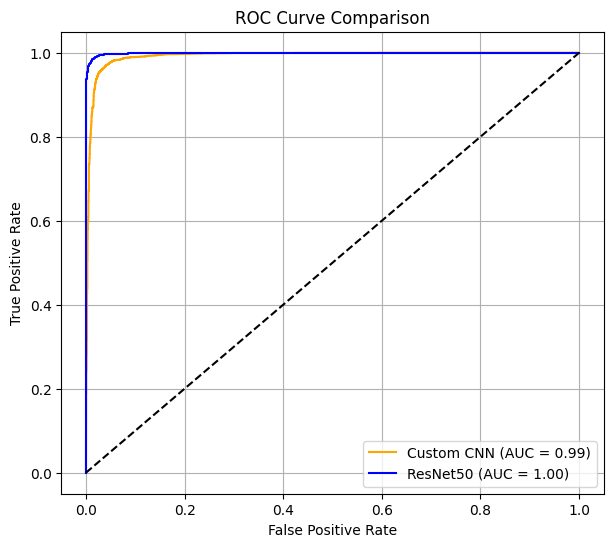

In [24]:
# ROC curve
fpr_cnn, tpr_cnn, _ = roc_curve(y_true, probs_cnn)
fpr_resnet, tpr_resnet, _ = roc_curve(y_true, probs_resnet)
auc_cnn = auc(fpr_cnn, tpr_cnn)
auc_resnet = auc(fpr_resnet, tpr_resnet)

plt.figure(figsize=(7, 6))
plt.plot(fpr_cnn, tpr_cnn, label=f'Custom CNN (AUC = {auc_cnn:.2f})', color='orange')
plt.plot(fpr_resnet, tpr_resnet, label=f'ResNet50 (AUC = {auc_resnet:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

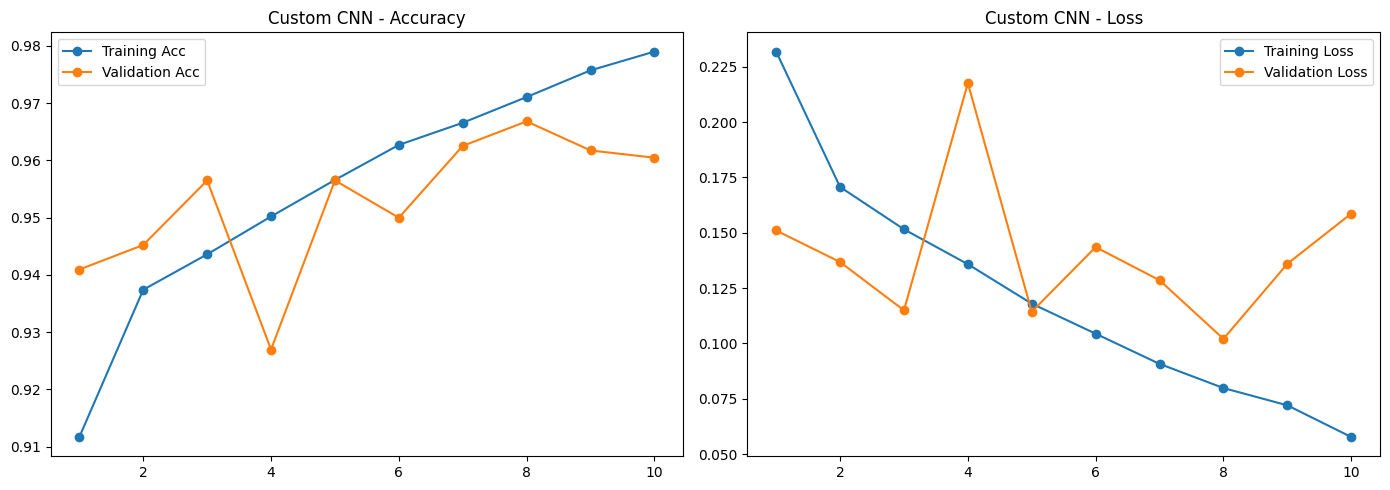

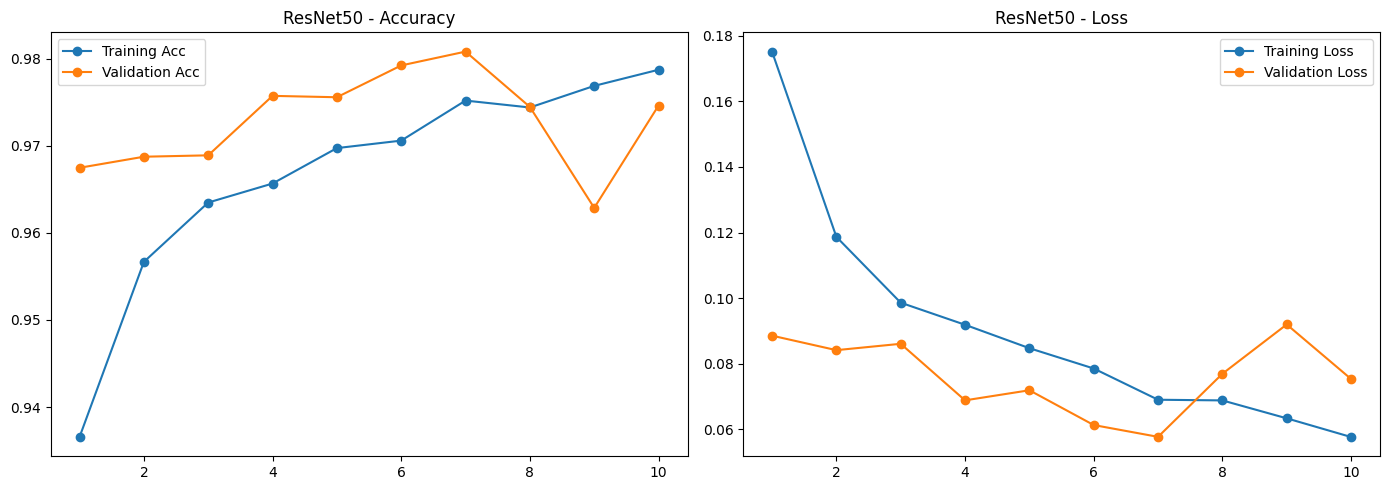

In [25]:
# Training Loss and Accuracy Curve

def plot_training(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'o-', label='Training Acc')
    plt.plot(epochs, val_acc, 'o-', label='Validation Acc')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'o-', label='Training Loss')
    plt.plot(epochs, val_loss, 'o-', label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot both
plot_training(cnn, "Custom CNN")
plot_training(resnet, "ResNet50")
